<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ, 2024</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Библиотека sklearn и классификация с помощью KNN</b></h1>

## Описание домашнего задания

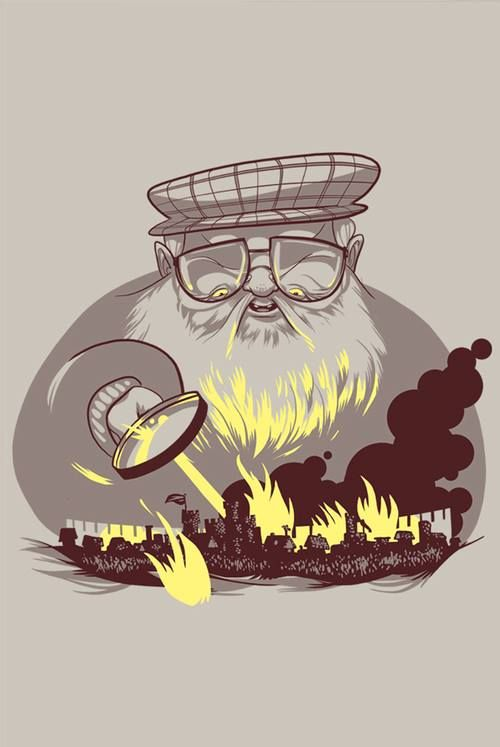

В данном задании вы будете работать с датасетом о персонажах из вселенной Игры Престолов [A Wiki of Ice and Fire](http://awoiaf.westeros.org/). Вам предстоит предсказать, кто из персонажей умрет, а кто останется вживых.



Описание данных:

* **name**: Имя персонажа

* **Title**: Социальный статус или знатность

* **House**: Дом, к которому принадлежит персонаж

* **Culture**: Социальная группа, к которой принадлежит персонаж

* **book1/2/3/4/5**: Появление персонажа в книге

* **Is noble**: Знатность персонажа, основанное на титуле

* **Age**: Отсчет времени: 305 AC

* **male**: Мужчина или женщина

* **dateOfBirth**: дата рождения

* **Spouse**: Имя супруги\а персонажа

* **Father**: Имя отца персонажа

* **Mother**: Имя матери персонажа

* **Heir**: Имя наследника персонажа

* **Is married**: Represents whether the character is married

* **Is spouse alive**: Represents whether character's spouse is alive

* **Is mother alive:** Жива ли мать персонажа

* **Is heir alive:** Жив ли наследник персонажа

* **Is father alive:** Указывает, жив ли отец персонажа

* **Number dead relations:** Количество умерших персонажей, с которыми персонаж связан

* **Popularity score:** Количество внутренних входящих и исходящих ссылок на страницу персонажей в вики http://awoiaf.westeros.org

Целевая переменная:
* **isAlive**: жив ли персонаж в книге

Оценивание:

Баллы считаются следующим образом:

1) $1.00 \geqslant score \geqslant 0.84$ --- 5 баллов

2) $0.84 > score \geqslant 0.77$ --- 4 балла

3) $0.77 > score \geqslant 0.70$ --- 3 балла

4) $0.70 > score \geqslant 0.65$ --- 2 балла

5) $0.65 > score \geqslant 0.6$ --- 1 балл

6) $0.60 > score$ --- 0 баллов

## Часть 1. Анализ и предобработка данных

Здесь вам необходимо сделать все шаги, которые обсуждались в первой части семинара.
* Предобработка данных
  * Обработка пропущенных данных
  * Создание новых признаков
  * Удаление ненужных столбцов
* Анализ данных
  * Анализ целевой переменной
  * Анализ признаков
  * Анализ влияния признаков на целевую переменную
* Подготовка данных для обучения модели

Загружаем датасет

In [1]:
!gdown 1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3 # test dataset
!gdown 1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v # train dataset

Downloading...
From: https://drive.google.com/uc?id=1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3
To: /content/game_of_thrones_test.csv
100% 37.3k/37.3k [00:00<00:00, 51.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v
To: /content/game_of_thrones_train.csv
100% 138k/138k [00:00<00:00, 38.5MB/s]


**Задание 1.1.** Импортируйте библиотеки pandas, matplotlib, seaborn

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from polars import col

**Задание 1.2.** Загрузите датасет в Pandas DataFrame при помощи функции `read_csv`. Вместо дефолтных наименований строк `0,1,...`, при помощи параметра `index_col`, сделайте значения колонки `S.No` наименованиями строк:

In [4]:
data = pl.read_csv("/content/game_of_thrones_train.csv") # index_col в поларсе автоматический
test = pl.read_csv("/content/game_of_thrones_test.csv") # загружу сразу и объединю с трейном

In [16]:
data = data.with_columns(
    is_test = pl.lit(False)
)

test = test.with_columns(
    isAlive = pl.lit(0).cast(pl.Int64()),
    is_test = pl.lit(True)
)

In [17]:
data = data.vstack(test)

In [18]:
dict(zip(data.columns, data.dtypes))

{'S.No': Int64,
 'name': String,
 'title': String,
 'male': Int64,
 'culture': String,
 'dateOfBirth': Float64,
 'mother': String,
 'father': String,
 'heir': String,
 'house': String,
 'spouse': String,
 'book1': Int64,
 'book2': Int64,
 'book3': Int64,
 'book4': Int64,
 'book5': Int64,
 'isAliveMother': Float64,
 'isAliveFather': Float64,
 'isAliveHeir': Float64,
 'isAliveSpouse': Float64,
 'isMarried': Int64,
 'isNoble': Int64,
 'age': Float64,
 'numDeadRelations': Int64,
 'popularity': Float64,
 'isAlive': Int64,
 'is_test': Boolean}

**Задание 1.3.** Предобработка (очистка) данных.

Проанализируйте, если в колонках NaN значения. Если есть, примите решение, как вы их будете обрабатывать. Вы можете либо удалить их, либо заполнить каким нибудь значением (например, медианой или модой).

In [19]:
data.select(pl.all().is_null().sum())

S.No,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,is_test
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,1008,0,1269,1513,1925,1920,1923,427,1670,0,0,0,0,0,1925,1920,1923,1670,0,0,1513,0,0,0,0


In [ ]:
# title, dateOfBirth,	mother,	father,	heir,	house,	spouse, name - будут удалены, поэтому не трогаю,
# isAlive... можно модой (т.е. 0),
# age - нулём
# culture - пустой строкой

In [20]:
data = data.with_columns(
    age=col("age").fill_null(0),
    culture=col("culture").fill_null("")
)

data = data.fill_null(0)

In [21]:
data.select(pl.all().is_null().sum())

S.No,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,is_test
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,1008,0,0,0,1925,1920,1923,427,1670,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Задание 1.4.** Создайте новые признаки.
* Создайте признак isPopular. У вас есть в таблице признак popularity score, поставьте какой то порог, например, 0.5, и пусть те персонажи, у которых popularity score меньше 0.5, непопулярны, т.е. isPopular = 0. Если же выше 0.5, тогда пусть isPopular=1.
* Создайте признак boolDeadRelations. Давайте упростим признак numDeadRelations, и просто поделим людей на тех, у кого были хоть какие то отношения с мертвыми персонажами, т.е. numDeadRelations > 0, и те, у которых не было, т.е. numDeadRelations = 0.
* Упростите признак culture, объединив схожие названия в один.


In [174]:
# Подсказка
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}


mapping = {value: key for key, values in cult.items() for value in values} # распаковка списков в ключи

In [23]:
data = data.with_columns(
    isPopular=pl.when(col("popularity") >= 0.5).then(1).otherwise(0),
    boolDeadRelations=pl.when(col("numDeadRelations") > 0).then(1).otherwise(0),
    culture=col("culture").str.to_lowercase().replace(mapping)
)

**Задание 1.5.** Проанализируйте, какие столбцы являются существенными и влияют на предсказание, а какие нет. Удалите ненужные столбцы по вашему мнению.

In [24]:
data = data.drop(
    "title", # слишком много уник.значении
    "dateOfBirth", # почти что дубликат age
    "mother", # далее просто имена
    "father",
    "heir",
    "house",
    "spouse",
    "name",
)

**Задание 1.6.** Проанализируйте целевую переменную. Посмотрите, является ли она категориальной или количественной. Так как мы говорим о задаче классификации, проанализируйте является ли датасет сбалансированным по классам или нет.

> Посмотрите, является ли она категориальной или количественной
 - я не понял вопроса, у нас задача классификации, какая количественная



In [26]:
data.filter(col("is_test") == False).group_by("isAlive").len() # баланса нет, так что бейзлайн = всем ставим 1

isAlive,len
i64,u32
0,345
1,1212


**Задание 1.7.** Проанализируйте признаки.
  * Обработайте категориальные признаки и переведите их в числа. Можете выбрать любой кодировщик.
  * Проанализируйте количественные признаки. Есть ли корреляция между признаками?

In [27]:
data = data.to_dummies(columns=["culture"], drop_first=True)

In [28]:
num_features = [
    "age",
    "numDeadRelations",
    "popularity",
]

In [29]:
corr = data.select(num_features).to_pandas().corr()

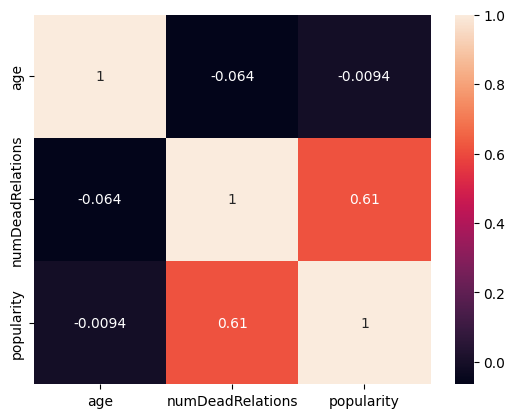

In [30]:
sns.heatmap(data=corr, annot=True);

**Задание 1.8.** Проанализируйте влияние признаков на целевую переменную.

In [31]:
cat_features = [  # уберу все culture_..., а то и так много фичей
  'book1',
  'book2',
  'book3',
  'book4',
  'book5',
  'isAliveMother',
  'isAliveFather',
  'isAliveHeir',
  'isAliveSpouse',
  'isMarried',
  'isNoble',
  'isPopular',
  'boolDeadRelations',
  "male"
]

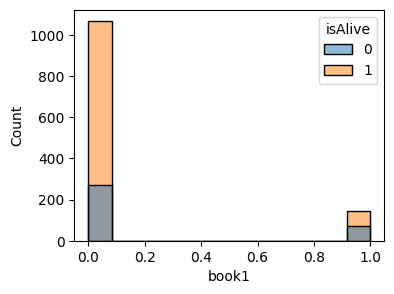

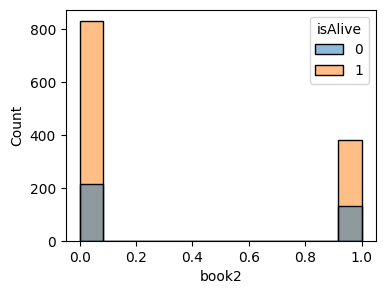

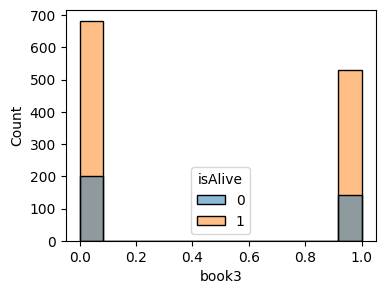

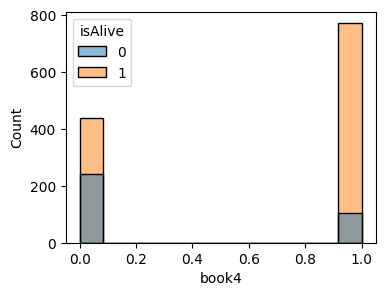

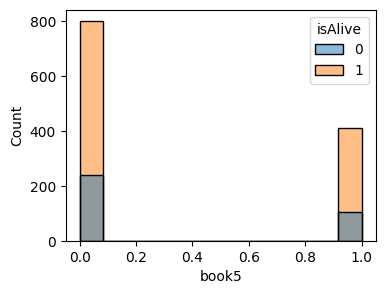

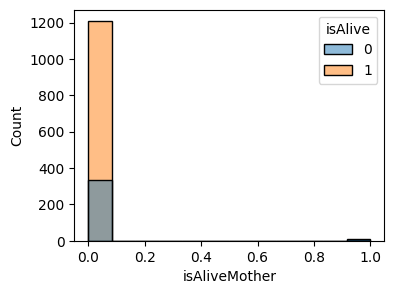

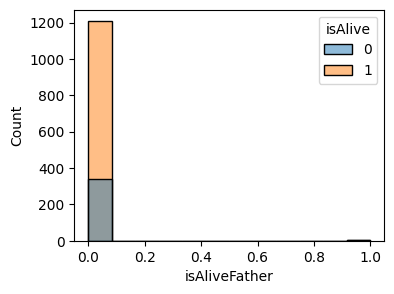

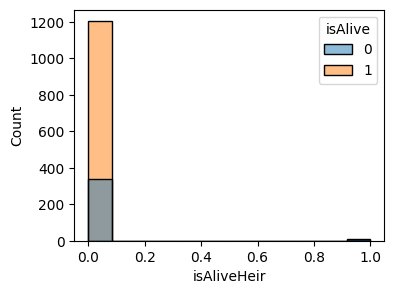

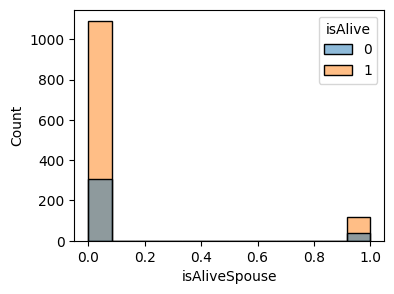

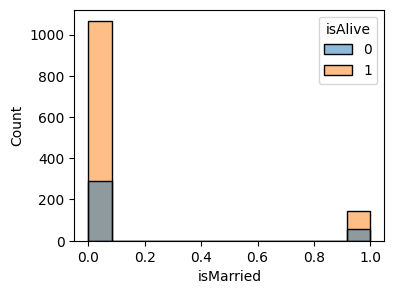

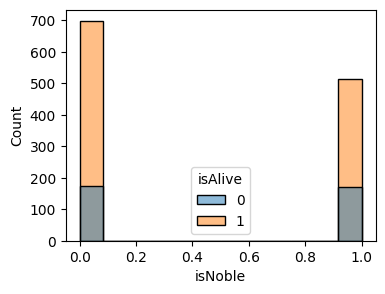

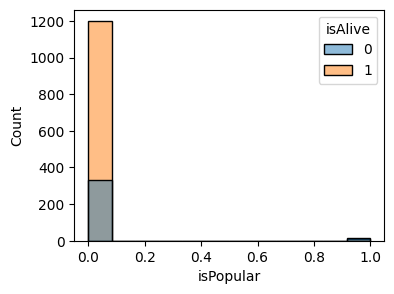

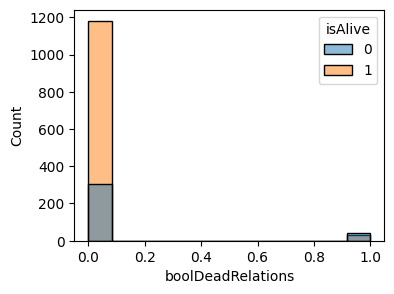

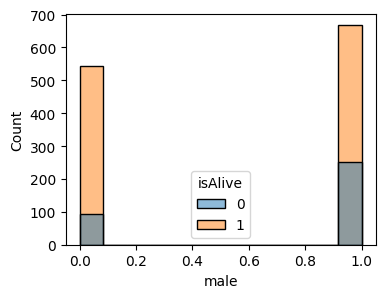

In [32]:
for cat_feature in cat_features:
  plt.figure(figsize=(4, 3))
  sns.histplot(data=data.filter(col("is_test") == False), x=cat_feature, hue="isAlive")

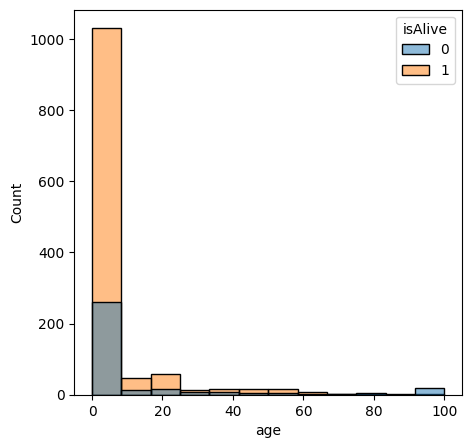

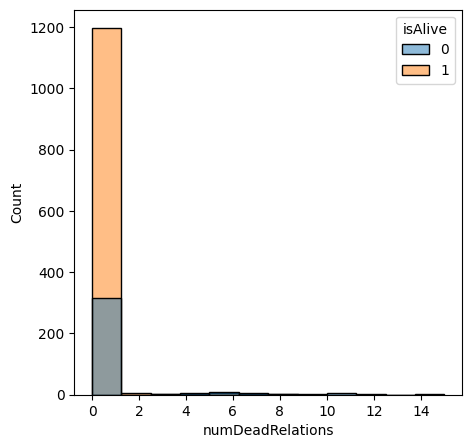

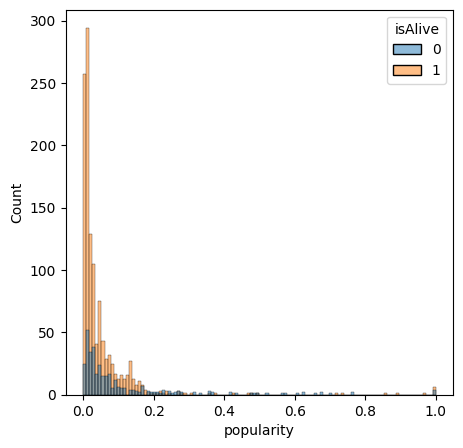

In [34]:
for num_feature in num_features:
  plt.figure(figsize=(5, 5))
  sns.histplot(data=data.filter(col("is_test") == False), x=num_feature, hue="isAlive");

**Задание 1.9.** Создайте переменные `X`, которая будет хранить только значения признаков, и `y`, которая будет хранить только значения целевой переменной.

In [37]:
## делим обратно на трейн и глобальный тест, после всех преобразовании

train = (
    data
    .filter(col("is_test") == False)
    .to_pandas()
    .set_index("S.No")
)


global_test = (
    data
    .filter(col("is_test") == True)
    .to_pandas()
    .set_index("S.No")
    .drop(columns=["isAlive"])
)


X = train.drop(columns=["isAlive"])
y = train["isAlive"]

**Задание 1.10.** Разделите датасет на train и test часть при помощи функции `train_test_split`

In [39]:
from sklearn.model_selection import train_test_split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Часть 2. Обучение моделей

В данной части домашнего задания, мы хотим научиться обучать модели для задачи классификации на наших данных.

**Задание 2.1.** Импортируйте следующие модели из библиотеки `sklearn`
* LogisticRegression
* RandomForestClassifier
* AdaBoostClassifier
* GaussianProcessClassifier
* GaussianNB
* KNeighborsClassifier
* SVC
* DecisionTreeClassifier


В качестве примера, импортируем модель `LogisticRegression`

In [42]:
from sklearn.linear_model import LogisticRegression

Импортируйте остальные модели из библиотеки `sklearn`. Чтобы понять как это сделать, воспользуйтесь официальный документацией `sklearn` $→$ [тык](https://scikit-learn.org/dev/user_guide.html). По ключевому названию модели, вы сможете найти необходимую информацию о том, как можно импортировать модель из библиотеки.

In [43]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

**Задание 2.2.** Обучите модель и сделайте предсказание на тестовой выборке

В качестве примера, обучим модель `LogisticRegression` и сделаем на ней предсказания на тестовой выборке.

In [71]:
# Шаг 1. создание модели
logistic_regression = LogisticRegression(C=1, solver="newton-cholesky", max_iter=200)

# Шаг 2. обучение модели
logistic_regression.fit(X_train, y_train)

# Шаг 3. Предсказание на тестовых данных
y_pred = logistic_regression.predict(X_test)

Аналогичным образом обучите остальные модели и сделайте предсказания на тестовой выборке.

In [45]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

**Я ОБЪЕДИНЮ ДВА ШАГА В ОДИН. СМ.НИЖЕ**

## Часть 3. Оцените качество моделей

Вам необходимо познакомиться с метриками задачи классификации из sklearn. Оцените все модели и выберите лучшую по метрике качества Accuracy.

С метриками классификации вы можете ознакомиться в [Yandex ML Book](https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii).

Для простоты в данном домашнем задании мы будем работать с самой базовой метрикой для задачи классификации - accuracy.

**Задание 3.1.** Вам необходимо посчитать метрику для всех моделей и выбрать лучшую модель.

Сначала импортируем необходимую функцию из библиотеки sklearn для подсчета accuracy.

In [41]:
from sklearn.metrics import accuracy_score

В качестве примера, посчитаем метрику accuracy для модели `LogisticRegression`

In [84]:
# Шаг 3. Предсказание на тестовых данных
y_pred = logistic_regression.predict(X_test)

# Шаг 4. Оценка предсказания по метрике accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : %.4f" % accuracy)

Accuracy : 0.7846


Аналогичным образом посчитайте метрику accuracy для остальных моделей

In [94]:
models = [
  AdaBoostClassifier,
  RandomForestClassifier,
  GaussianProcessClassifier,
  GaussianNB,
  KNeighborsClassifier,
  SVC,
  DecisionTreeClassifier,
]

best_model = None
curr_acc = 0

for model in models:
  curr_model = model()
  print(type(curr_model))

  curr_model.fit(X_train, y_train)
  pred = curr_model.predict(X_test)

  accuracy = accuracy_score(y_test, pred)
  if accuracy > curr_acc:
    best_model = curr_model
    curr_acc = accuracy
  print(f"Accuracy: %.4f" % accuracy)

print(f"BEST MODEL IS {type(best_model)}")

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Accuracy: 0.8179
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy: 0.8231
<class 'sklearn.gaussian_process._gpc.GaussianProcessClassifier'>
Accuracy: 0.7974
<class 'sklearn.naive_bayes.GaussianNB'>
Accuracy: 0.2795
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Accuracy: 0.8128
<class 'sklearn.svm._classes.SVC'>
Accuracy: 0.7923
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy: 0.8179
BEST MODEL IS <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [83]:
import numpy as np

In [82]:
baseline = np.ones(y_test.shape)
accuracy_score(y_test, baseline)

0.7666666666666667

Ну хотя бы бейзлайн побили)

Выберите лучшую модель.

### Файл `submission.csv`

Вам нужно вместо значений в `submission.csv` файле в колонке `isAlive`, подставить свои предсказания и сохранить измененный файл.

In [54]:
import pandas as pd

In [52]:
!gdown 1M14conWjAW2QLoyCXbHEAy8bql2f99eF

Downloading...
From: https://drive.google.com/uc?id=1M14conWjAW2QLoyCXbHEAy8bql2f99eF
To: /content/submission.csv
100% 2.74k/2.74k [00:00<00:00, 9.63MB/s]


In [85]:
submission = pd.read_csv("/content/submission.csv", index_col='S.No')

In [86]:
global_pred = best_model.predict(global_test)

In [87]:
submission["isAlive"] = global_pred

In [88]:
submission.head()

,isAlive
S.No,
1558,0
1559,1
1560,1
1561,1
1562,0


Как сохранить измененный Pandas DataFrame в csv файл:

In [89]:
submission.to_csv("/content/new_submission.csv", index=False)

Максимум что я выбил на моделях выше на глобал-тесте = 0.72

In [93]:
# все мы знаем, что на самом деле лучше :)
# Просто возьму из коробки без тюна и обучу на всём трейне

from catboost import CatBoostClassifier, Pool

In [248]:
data = pl.read_csv("/content/game_of_thrones_train.csv",)
test = pl.read_csv("/content/game_of_thrones_test.csv",)

In [249]:
data = data.with_columns(
    culture=col("culture").fill_null("")
)

data = data.with_columns(
    isPopular=pl.when(col("popularity") >= 0.5).then(1).otherwise(0),
    boolDeadRelations=pl.when(col("numDeadRelations") > 0).then(1).otherwise(0),
    # culture=col("culture").str.to_lowercase().replace(mapping)
)


test = test.with_columns(
    culture=col("culture").fill_null("")
)

test = test.with_columns(
    isPopular=pl.when(col("popularity") >= 0.5).then(1).otherwise(0),
    boolDeadRelations=pl.when(col("numDeadRelations") > 0).then(1).otherwise(0),
    # culture=col("culture").str.to_lowercase().replace(mapping)
)

In [250]:
data = data.to_pandas().set_index("S.No")
test = test.to_pandas().set_index("S.No")

In [251]:
X = data.drop(columns=["isAlive"])
y = data["isAlive"]

In [252]:
X = X.drop(columns=[
    "title",
    "dateOfBirth",
    "mother",
    "father",
    "heir",
    "house",
    "spouse",
    "name",
  ]
)

global_test = test.drop(
    columns=[
      "title",
      "dateOfBirth",
      "mother",
      "father",
      "heir",
      "house",
      "spouse",
      "name",
    ]
)

In [191]:
X.columns

Index(['male', 'culture', 'book1', 'book2', 'book3', 'book4', 'book5',
       'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse',
       'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity'],
      dtype='object')

In [253]:
train_pool = Pool(
    data=X,
    label=y,
    cat_features=[
        "culture"
    ]
)

In [254]:
model = CatBoostClassifier(n_estimators=2500)

In [255]:
model.fit(train_pool)

Learning rate set to 0.005372
0:	learn: 0.6900118	total: 4.12ms	remaining: 10.3s
1:	learn: 0.6865001	total: 7.68ms	remaining: 9.59s
2:	learn: 0.6831785	total: 10.6ms	remaining: 8.82s
3:	learn: 0.6800377	total: 14.5ms	remaining: 9.03s
4:	learn: 0.6767666	total: 18.1ms	remaining: 9.01s
5:	learn: 0.6738045	total: 22ms	remaining: 9.15s
6:	learn: 0.6705909	total: 25.6ms	remaining: 9.11s
7:	learn: 0.6674990	total: 29ms	remaining: 9.03s
8:	learn: 0.6648759	total: 32.4ms	remaining: 8.97s
9:	learn: 0.6619919	total: 36.2ms	remaining: 9.01s
10:	learn: 0.6591357	total: 39.7ms	remaining: 8.99s
11:	learn: 0.6562766	total: 43.3ms	remaining: 8.98s
12:	learn: 0.6536520	total: 46.8ms	remaining: 8.95s
13:	learn: 0.6509017	total: 50.3ms	remaining: 8.93s
14:	learn: 0.6482334	total: 53.9ms	remaining: 8.93s
15:	learn: 0.6449635	total: 57.1ms	remaining: 8.87s
16:	learn: 0.6431145	total: 60.6ms	remaining: 8.85s
17:	learn: 0.6407960	total: 64ms	remaining: 8.83s
18:	learn: 0.6378518	total: 67.6ms	remaining: 8.83

In [256]:
global_pred = model.predict(global_test)

In [257]:
submission["isAlive"] = global_pred

In [258]:
submission.to_csv("/content/new_submission.csv", index=False)

In [227]:
# 0.7455 - максимум, больше времени тратить не буду :)